From https://juliateachingctu.github.io/Julia-for-Optimization-and-Learning/dev/lecture_08/theory/

<h3> Visualization of gradients </h3>
For the numerical experiments, we will consider the following function

$f(x) = sin(x_1 + x_2) + cos(x_1)^2$

on domain [-3,1]x[-2,1]

Write a function $g(x)$ which computes the derivative of $f$ at a point x.

In [577]:
f(x) = sin(x[1] + x[2]) + cos(x[1])^2
f(x1,x2) = f([x1;x2]) # overload for f
g(x) = [cos(x[1] + x[2]) - 2 * cos(x[1]) * sin(x[1]); cos(x[1] + x[2])] # gradient of f by x1, x2
g(x1,x2) = g([x1;x2]) # overload for g

# test
x=[1.0, 2.0]
println("f(x) = ", f(x))
println("g(x) = ", g(x))

f(x) = 0.43304658978629607
g(x) = [-1.8992899234261271, -0.9899924966004454]


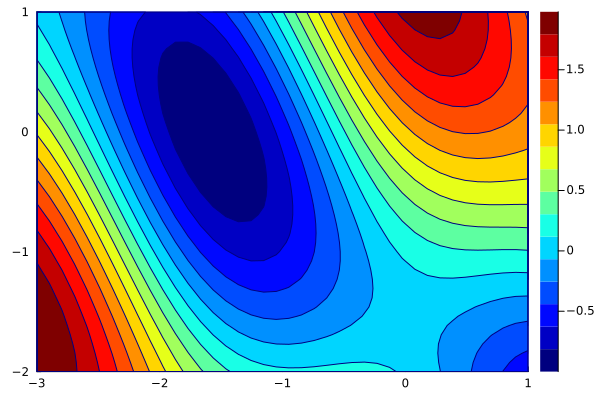

In [578]:
using Plots

xs = range(-3, 1, length = 40)
ys = range(-2, 1, length = 40)

contourf(xs, ys, f, color = :jet)

<h3> Computation of gradients </h3>

<h4> Finite Difference Method </h4>
Compute the approximation of $f'(x)$ by finite differences, using

\begin{equation}
f'(x) ≈ \frac{f(x+h)-f(x)}{h}
\end{equation}

with $f:\mathbb{R} \rightarrow \mathbb{R}$, a point $x \in \mathbb{R}$, and an optional input $h \in \mathbb{R}$.

In [579]:
# Slow implementation of finite difference.
function finite_difference(f, x::Real; h=1e-8)
    (f(x+h) - f(x)) / h
end

finite_difference (generic function with 1 method)

In [580]:
x = [-2, -1]
# To fix the first argument, create anonymus function taking x1 = -2 that varies on y.
fin_diff(h) =finite_difference(y -> f(x[1], y), x[2], h=h)
true_grad = g(x)[2] # true gradient of f by x2

# Discretisation of h (logarithmic scale, range used as exponent)
hs = 10.0 .^ (-15:0.01:-1)

1401-element Vector{Float64}:
 1.0e-15
 1.0232929922807536e-15
 1.0471285480508984e-15
 1.071519305237605e-15
 1.0964781961431829e-15
 1.1220184543019653e-15
 1.1481536214968841e-15
 1.1748975549395303e-15
 1.202264434617413e-15
 1.2302687708123812e-15
 ⋮
 0.08317637711026708
 0.08511380382023763
 0.08709635899560805
 0.08912509381337454
 0.09120108393559097
 0.0933254300796991
 0.09549925860214359
 0.09772372209558107
 0.1

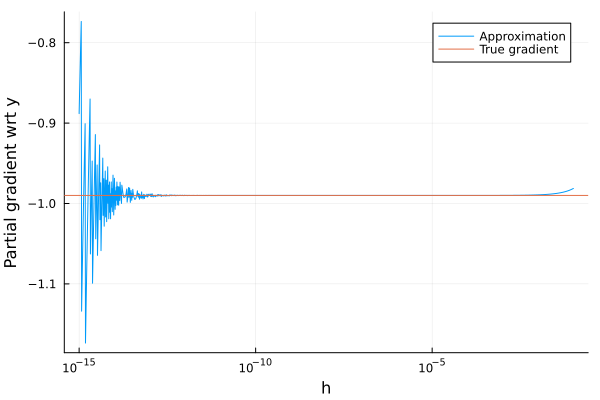

In [581]:
plot(hs, fin_diff,
    xlabel = "h",
    ylabel = "Partial gradient wrt y",
    label = ["Approximation" "True gradient"],
    xscale = :log10,
)

hline!([true_grad]; label =  "True gradient")

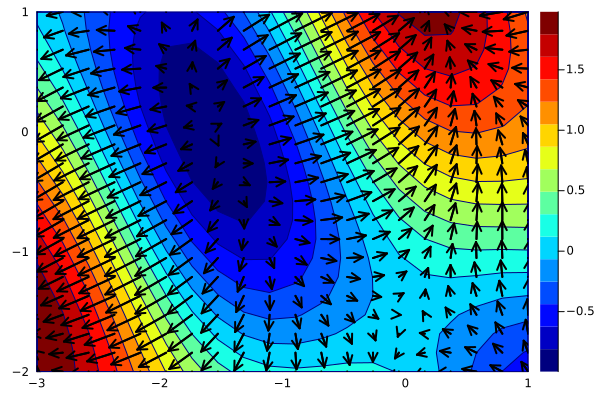

In [582]:
xs = range(-3, 1, length = 20)
ys = range(-2, 1, length = 20)

# Plot the contour lines of f.
plt = contourf(xs, ys, f;
    xlims = (minimum(xs), maximum(xs)),
    ylims = (minimum(ys), maximum(ys)),
    color = :jet
)

α = 0.15 # Length of the gradient arrow.
for x1 in xs, x2 in ys
    x = [x1; x2]

    # The true gradient of x (x1, x2) of length α.
    x_grad = [x x.+α.*g(x)]

    plot!(x_grad[1, :], x_grad[2, :];
        line = (:arrow, 2, :black), # Traces the arrows.
        label = "",
    )
end
display(plt)

<h3> Unconstrained optimization </h3>

Unconstrained optimization means that we optimize a function on $\mathbb{R}^n$. We are looking to minimize $f(x)$, by finding a global minimum $x \in X$ which satisfies $f(x)\leq f(y)$ for all $y \in X$.

<h5>Theorem: Connection between optimization problems and gradients</h5>

Consider a differentiable function $f$ over $X = \mathbb{R}^n$. If $x$ is in its local minimum, then $\nabla f(x)=0$. Conversely, if $f$ in convex, then every point $x$ with $\nabla f(x)=0$ is a global minimum of f.

This theorem applies only if X is the whole space.

<h5> Gradient descent </h5>
Since the gradient is the direction of the steepest ascent, the straightforward idea is to move in the opposite direction. This gives rise to the gradient (or steepest) descent algorithm

$x^{k+1}=x^k - \alpha^k \nabla f(x^k)$, where $\alpha^k$ is the step size.

The step size is usually fixed and determined before execution. However, some methods (here the Armijo condition), adjust the step size.

Armijo condition: $\alpha^k$ satisfying $f(x^{k+1})=f(x^k -\alpha^k \nabla f(x^k))\leq f(x^k) - c \alpha^k || \nabla f(x^k)||^2$ with $c$ a small constant with $c \in (0,1)$, usually $c=10^{-4}$.

The Armijo condition ensures that the sequence of function values is strictly decreasing (thus prevents oscillation), since it ensures the difference $f(x^{k+1})-f(x^k)$ is limited to a function of $x^k$.

Therefore, to find some 
$\alpha$ satisfying the Armijo conditions, we start with some $\alpha_{max}$ and divide it by two until the condition is satisfied.

In [583]:
# Gradient descent over n=100 iterations.
# g is the gradient of the function f.
# Why doesn't it work when f is not provided?
function optim(f, g, x, α; max_iter=100)
    xs = zeros(length(x), max_iter+1)
    xs[:,1] = x
    for i in 1:max_iter
        x -= α*g(x)
        xs[:,i+1] = x
    end
    return xs
end

optim (generic function with 6 methods)

In [584]:
#Helper function to create an animation of the optimization path from https://juliateachingctu.github.io/Julia-for-Optimization-and-Learning/dev/lecture_08/unconstrained/
#Expects path to be a matrix. Each column is a point in the path.
using Random

function create_anim(
    f,
    path,
    xlims,
    ylims,
    file_name = joinpath(pwd(), randstring(12) * ".gif");
    xbounds = xlims,
    ybounds = ylims,
    fps = 15,
)
    xs = range(xlims...; length = 100)
    ys = range(ylims...; length = 100)
    plt = contourf(xs, ys, f; color = :jet)

    # add constraints if provided
    if !(xbounds == xlims && ybounds == ylims)
        x_rect = [xbounds[1]; xbounds[2]; xbounds[2]; xbounds[1]; xbounds[1]]
        y_rect = [ybounds[1]; ybounds[1]; ybounds[2]; ybounds[2]; ybounds[1]]

        plot!(x_rect, y_rect; line = (2, :dash, :red), label="")
    end

    # add an empty plot
    plot!(Float64[], Float64[]; line = (4, :arrow, :black), label = "")

    # extract the last plot series
    plt_path = plt.series_list[end]

    # create the animation and save it
    anim = Animation()
    for x in eachcol(path)
        push!(plt_path, x[1], x[2]) # add a new point
        frame(anim)
    end
    gif(anim, file_name; fps = fps, show_msg = false)
    return nothing
end

create_anim (generic function with 2 methods)

Use the implementation of the gradient descent to minimize the function $f(x) = sin(x_1 + x_2) + cos(x_1)^2$ from the starting point $x_0=(0,-1)$, with $\alpha = 0.1$.

In [585]:
# Compute gradient descent with α=0.1 from the initial point x0=[0, -1].
xs = optim([], g, [0.0; -1.0], 0.1)

# Create an animation of the optimization path.
xlims = (-3, 1)
ylims = (-2, 1)
create_anim(f, xs, xlims, ylims, "anim1.gif")

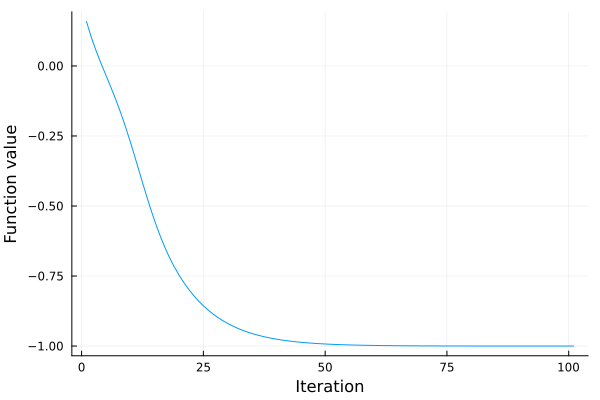

In [586]:
f_gd = [f(x) for x in eachcol(xs)]

plot(f_gd, label="", xlabel="Iteration", ylabel="Function value")

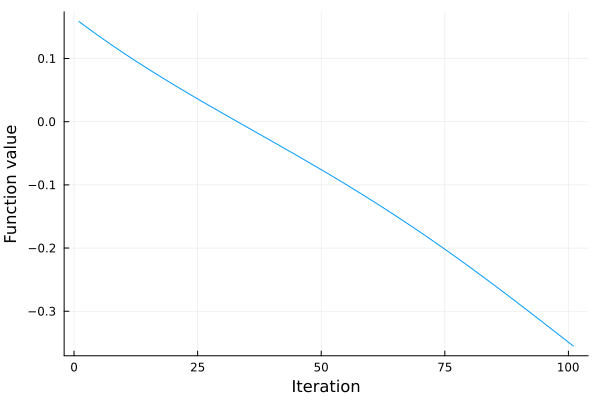

In [587]:
# Reduce step size to 0.01, convergence is slower.
x_gd = optim([], g, [0; -1], 0.01)

create_anim(f, x_gd, xlims, ylims, "anim2.gif")
f_gd = [f(x) for x in eachcol(x_gd)]

plot(f_gd, label="", xlabel="Iteration", ylabel="Function value")

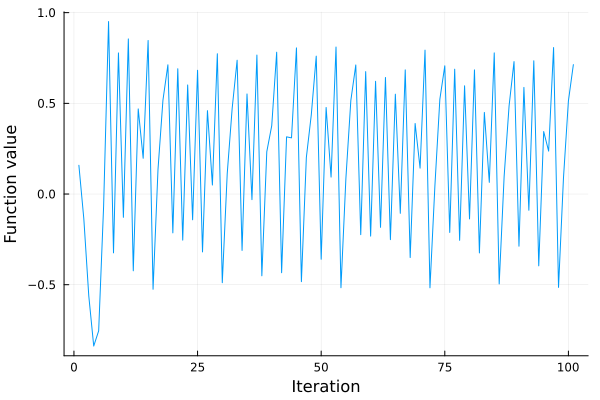

In [588]:
# Increase step size to 1, no convergence.
x_gd = optim([], g, [0; -1], 1)

create_anim(f, x_gd, xlims, ylims, "anim3.gif")
f_gd = [f(x) for x in eachcol(x_gd)]

plot(f_gd, label="", xlabel="Iteration", ylabel="Function value")

<h5> Adaptive step size </h5>

In [589]:
# Elegant way of adapting the step size : abstract type and method to adapt step size.
abstract type Step end

# Gradient descent type GD, substype of Step.
struct GD <: Step
    α::Float64
end

# Method to optimize the step size.
optim_step(s::GD, f, g, x) = -s.α*g(x)

optim_step (generic function with 2 methods)

In [590]:
# Gradient descent using step abstract type : optim step is defined the same way as before.
function optim2(f, g, x, s::Step; max_iter=100)
    xs = zeros(length(x), max_iter+1)
    xs[:,1] = x
    for i in 1:max_iter
        x += optim_step(s, f, g, x)
        xs[:,i+1] = x
    end
    return xs
end

optim2 (generic function with 2 methods)

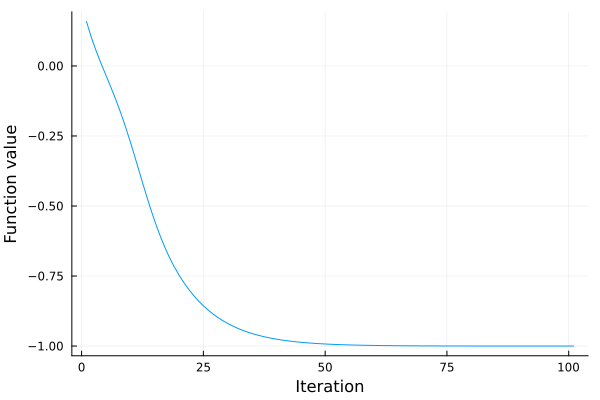

In [591]:
# No changes, optim_step uses a constant value for α.
gd = GD(0.1)
x_opt = optim2(f, g, [0;-1], gd)

create_anim(f, x_opt, xlims, ylims, "anim4.gif")
f_gd = [f(x) for x in eachcol(x_opt)]

plot(f_gd, label="", xlabel="Iteration", ylabel="Function value")

Using Armijo's step size, select the next step based on current value gradient.

In [592]:
# New step subtype : Armijo's rule.
# Takes a constant c (usually 0.0001) and a maximum step size α_max.
struct Armijo <: Step
    c::Float64
    α_max::Float64
end

# Method to optimize the step size : Armijo's rule.
function optim_step(s::Armijo, f, g, x)
    fun = f(x)
    grad = g(x)
    α = s.α_max
    while f(x .- α*grad) > fun - s.c*α*(grad'*grad)
        α /= 2
        if α <= 1e-6
            warning("Armijo line search failed.")
            break
        end
    end
    return -α*grad
end

optim_step (generic function with 2 methods)

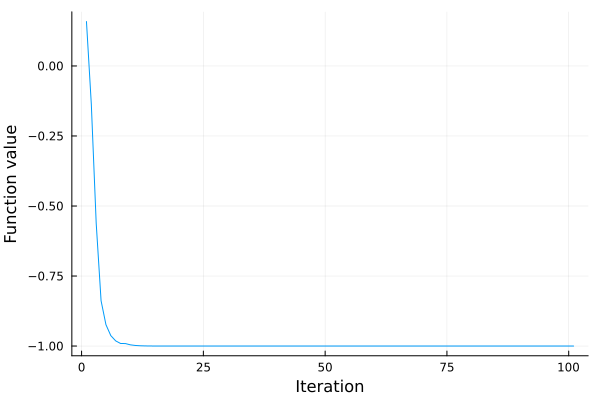

In [593]:
# Using Armjio's rule for step adaptation.
gd = Armijo(1e-4, 1)
x_opt = optim2(f, g, [0;-1], gd)

create_anim(f, x_opt, xlims, ylims, "anim5.gif")
f_gd = [f(x) for x in eachcol(x_opt)]

plot(f_gd, label="", xlabel="Iteration", ylabel="Function value")

Armijo converges much faster and with more accuracy. However, the calculations are more costly for each iteration than the standard gradient descent. 

<h4> Bisection Method </h4>

Similarly to Newton's method, the bisection method is primarily designed to solve equations by finding their zero points. It is only able to solve equations $f(x)=0$ where $f: \mathbb{R} \rightarrow \mathbb{R}$. It starts in an interval $[a,b]$ where $f$ has oppositve values $f(a)f(b)<0$. Then it selects the middle point on $[a,b]$ and halves the inverval so that the new interval again satisfies the constraint on opposite signs $f(a)f(b)<0$. This is repeated until the function value is small or until the interval has a small length. 

Implement the bisection method and use it to minimize $f(x)=x^2-x$ on $[-1,1]$. During the implementation, do not evaluate $f$ unless necessary.

In [596]:
#Bisection Method.
function bisection(f, interval)
   a, b = interval[1], interval[2]
   x0 = (a + b) / 2
   f0 = f(x0)
   while(abs(f0) > 1e-4)
    fa = f(a)
    fb = f(b)
    fa*fb > 0 && error("Wrong initial values for bisection")
    if fa * f0 < 0
        b = x0
    else
        a = x0
    end
    x0 = (a + b) / 2
    f0 = f(x0)
end
   return x0
end

bisection (generic function with 1 method)

In [600]:
f(x) = x^2 - x

# Appropriate values.
interval = [-1; 1]
x0 = bisection(f, interval)
print(x0)

# Error case.
interval = [0.4; 0.6]
x0 = bisection(f, interval)

0.0

ErrorException: Wrong initial values for bisection